In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import time

start_time = time.time()

In [2]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")

np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 10)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)

%matplotlib inline

pd.set_option('display.max_columns', 100)

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')
sns.set_palette("Paired")

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['text.color'] = 'k'

font = {'size'   : 10}

plt.rc('font', **font)


In [3]:
train_store = pd.read_pickle("../data/1_train_store_preprocessed.pkl").sort_values(['Store','Date'])
test_store = pd.read_pickle("../data/1_test_store_preprocessed.pkl").sort_values(['Store','Date'])

In [4]:
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm

In [5]:
import pandas as pd
from fbprophet import Prophet

In [6]:
N = 95
train_store_N = train_store[train_store['Store']==N]
test_store_N = test_store[test_store['Store']==N]

print(len(train_store_N),len(test_store_N))

train_store_N.tail()

942 0


,Store,DayOfWeek,Date,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
4554,95,1,2015-07-27,2015,7,1035,1,1,0,0,11134,1.0,0.0,1890.0,2.0,1.0,0.0,0.0,0.0,0.0
3439,95,2,2015-07-28,2015,7,922,1,1,0,0,9107,1.0,0.0,1890.0,2.0,1.0,0.0,0.0,0.0,0.0
2324,95,3,2015-07-29,2015,7,773,1,1,0,0,7776,1.0,0.0,1890.0,2.0,1.0,0.0,0.0,0.0,0.0
1209,95,4,2015-07-30,2015,7,794,1,1,0,0,7525,1.0,0.0,1890.0,2.0,1.0,0.0,0.0,0.0,0.0
94,95,5,2015-07-31,2015,7,920,1,1,0,0,8445,1.0,0.0,1890.0,2.0,1.0,0.0,0.0,0.0,0.0


In [7]:
df_tot = train_store_N[['Date','Sales']]
df_tot.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)
df_tot.head()

,ds,y
1016189,2013-01-01,0
1015074,2013-01-02,7770
1013959,2013-01-03,6522
1012844,2013-01-04,6723
1011729,2013-01-05,4644


In [8]:
# Do we sell on sundays?
df_tot[df_tot['ds'].dt.dayofweek == 6]['y'].value_counts()
# No...

0    134
Name: y, dtype: int64

In [25]:
# REMOVE SUNDAYS
# df = df_tot
df = df_tot[df_tot['ds'].dt.dayofweek < 6]
df.head(10)

,ds,y
1016189,2013-01-01,0
1015074,2013-01-02,7770
1013959,2013-01-03,6522
1012844,2013-01-04,6723
1011729,2013-01-05,4644
1009499,2013-01-07,11985
1008384,2013-01-08,10371
1007269,2013-01-09,9232
1006154,2013-01-10,8809
1005039,2013-01-11,7882


In [26]:
holidays_1 = train_store_N[['Date','StateHoliday','SchoolHoliday','Promo']]
holidays_1['StateHoliday'].value_counts(sort=False)

0    911
1     21
2      6
3      4
Name: StateHoliday, dtype: int64

In [27]:
holidays_test = test_store_N[['Date','StateHoliday','SchoolHoliday','Promo']]
holidays_test['StateHoliday'].value_counts(sort=False)

Series([], Name: StateHoliday, dtype: int64)

In [28]:
#holidays_1[['StateHoliday','SchoolHoliday','Promo']].value_counts(sort=False)

In [29]:
holidays_tot = pd.DataFrame()

In [30]:
holiday_col = 'StateHoliday' 

list_id = holidays_1[holiday_col].unique()

print(holiday_col)
for k in list_id:
    if k == 0:
        continue
    print(k,end=' - ')
    y = holidays_1[holidays_1[holiday_col]==k]['Date']
    holidays_2 = pd.DataFrame({
      'holiday': f'{holiday_col} - {k}',
      'ds': pd.to_datetime(y.to_list()),
      'lower_window': 0,
      'upper_window': 1,
    })
    y = holidays_test[holidays_test[holiday_col]==k]['Date']
    holidays_3 = pd.DataFrame({
      'holiday': f'{holiday_col} - {k}',
      'ds': pd.to_datetime(y.to_list()),
      'lower_window': 0,
      'upper_window': 1,
    })
    print(f'{len(holidays_2)}+{len(holidays_3)}',end='   ')
    holidays_tot = pd.concat((holidays_tot, holidays_2,holidays_3),ignore_index=True)
holidays_tot.tail()

StateHoliday
1 - 21+0   2 - 6+0   3 - 4+0   

,holiday,ds,lower_window,upper_window
26,StateHoliday - 2,2015-04-06,0,1
27,StateHoliday - 3,2013-12-25,0,1
28,StateHoliday - 3,2013-12-26,0,1
29,StateHoliday - 3,2014-12-25,0,1
30,StateHoliday - 3,2014-12-26,0,1


In [31]:
len(holidays_tot),len(df)

(31, 808)

In [32]:
m = Prophet(holidays=holidays_tot, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, seasonality_mode = 'multiplicative',
           changepoint_prior_scale=0.05)
m.add_country_holidays(country_name='DE')
#m2.add_regressor("my_holiday")
m.fit(df)

In [33]:
future = m.make_future_dataframe(periods=6*7, freq='D')
future.tail()

,ds
845,2015-09-07
846,2015-09-08
847,2015-09-09
848,2015-09-10
849,2015-09-11


In [34]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
845,2015-09-07,8125.401430,5974.959273,10485.135135
846,2015-09-08,7244.916126,4904.223001,9441.917001
847,2015-09-09,6225.722885,3987.734388,8360.669464
848,2015-09-10,6428.048594,4077.746635,8507.380749
849,2015-09-11,6447.326248,4237.408063,8670.011458


In [35]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christi Himmelfahrt,Christi Himmelfahrt_lower,Christi Himmelfahrt_upper,Erster Mai,Erster Mai_lower,Erster Mai_upper,Erster Weihnachtstag,Erster Weihnachtstag_lower,Erster Weihnachtstag_upper,Karfreitag,Karfreitag_lower,Karfreitag_upper,Neujahr,Neujahr_lower,Neujahr_upper,Ostermontag,Ostermontag_lower,Ostermontag_upper,Pfingstmontag,Pfingstmontag_lower,Pfingstmontag_upper,StateHoliday - 1,StateHoliday - 1_lower,StateHoliday - 1_upper,StateHoliday - 2,StateHoliday - 2_lower,StateHoliday - 2_upper,StateHoliday - 3,StateHoliday - 3_lower,StateHoliday - 3_upper,Tag der Deutschen Einheit,Tag der Deutschen Einheit_lower,Tag der Deutschen Einheit_upper,Zweiter Weihnachtstag,Zweiter Weihnachtstag_lower,Zweiter Weihnachtstag_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2013-01-01,11551.548838,-1666.606601,2672.894611,11551.548838,11551.548838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.405644,-0.405644,-0.405644,0.0,0.0,0.0,0.0,0.0,0.0,-0.370155,-0.370155,-0.370155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.300523,-0.300523,-0.300523,-0.775800,-0.775800,-0.775800,-0.956669,-0.956669,-0.956669,0.080721,0.080721,0.080721,0.038932,0.038932,0.038932,0.0,0.0,0.0,500.545504
1,2013-01-02,11551.359310,6343.996080,10641.616665,11551.359310,11551.359310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.038704,0.038704,0.038704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.300523,-0.300523,-0.300523,0.038704,0.038704,0.038704,-0.262501,-0.262501,-0.262501,-0.020906,-0.020906,-0.020906,0.020224,0.020224,0.020224,0.0,0.0,0.0,8519.117732
2,2013-01-03,11551.169781,5978.024878,10269.851049,11551.169781,11551.169781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.300523,-0.300523,-0.300523,0.000000,0.000000,0.000000,-0.297045,-0.297045,-0.297045,0.000899,0.000899,0.000899,0.002579,0.002579,0.002579,0.0,0.0,0.0,8119.954435
3,2013-01-04,11550.980252,5728.545001,10251.123983,11550.980252,11550.980252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.300523,-0.300523,-0.300523,0.000000,0.000000,0.000000,-0.310909,-0.310909,-0.310909,0.003432,0.003432,0.003432,-0.013818,-0.013818,-0.013818,0.0,0.0,0.0,7959.679735
4,2013-01-05,11550.790724,2088.249547,6957.577513,11550.790724,11550.790724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.300523,-0.300523,-0.300523,0.000000,0.000000,0.000000,-0.598707,-0.598707,-0.598707,-0.269370,-0.269370,-0.269370,-0.028814,-0.028814,-0.028814,0.0,0.0,0.0,4635.253165


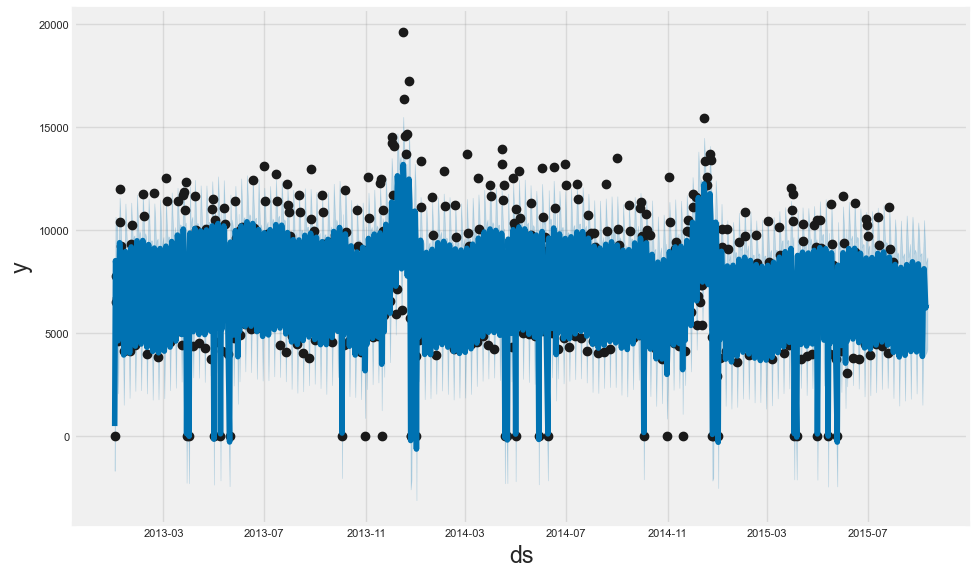

In [36]:
fig1 = m.plot(forecast)

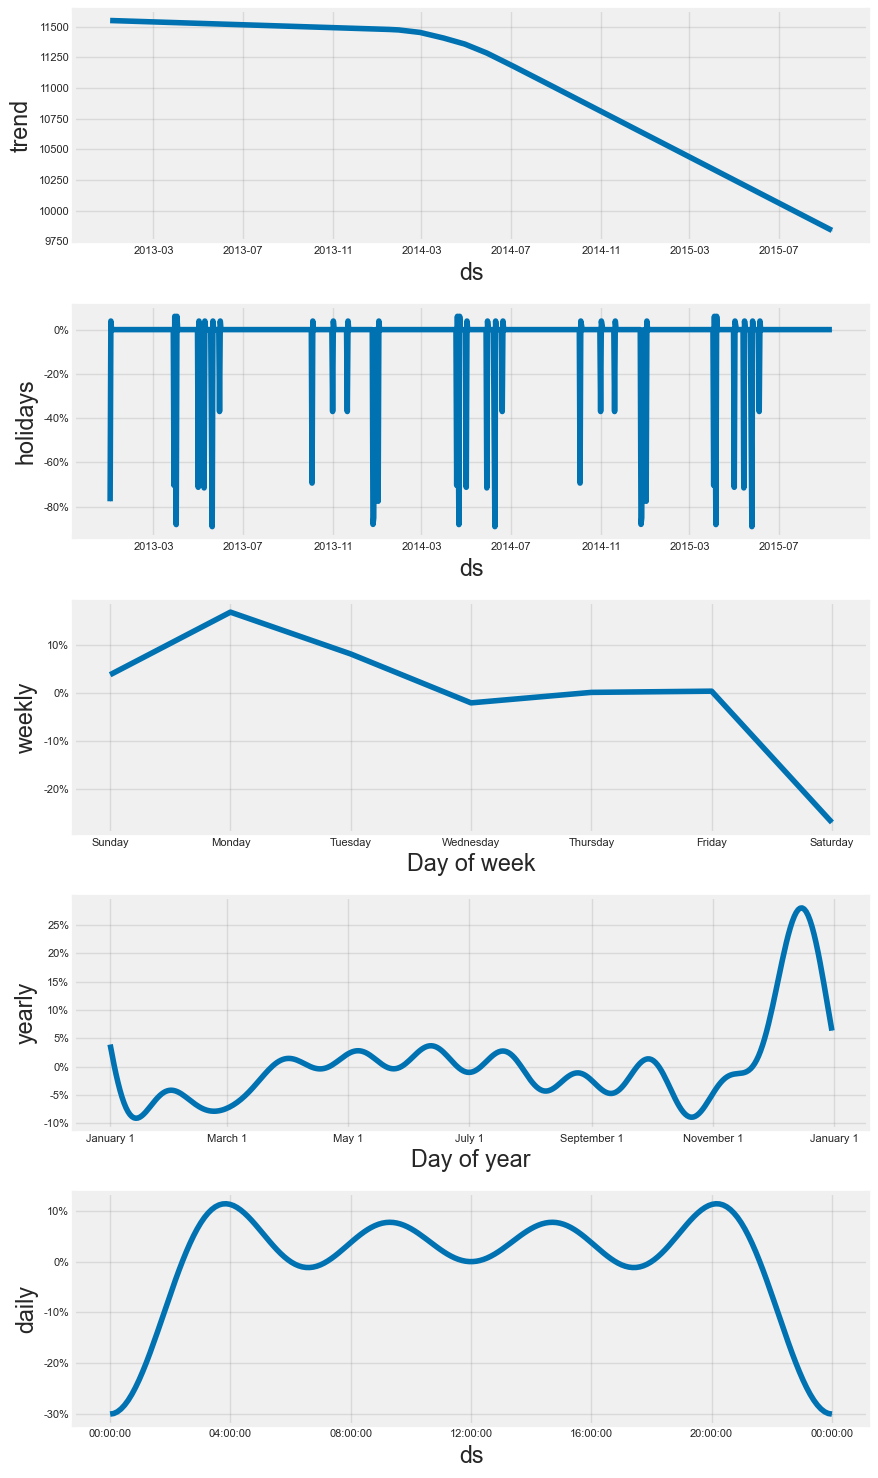

In [37]:
fig2 = m.plot_components(forecast)

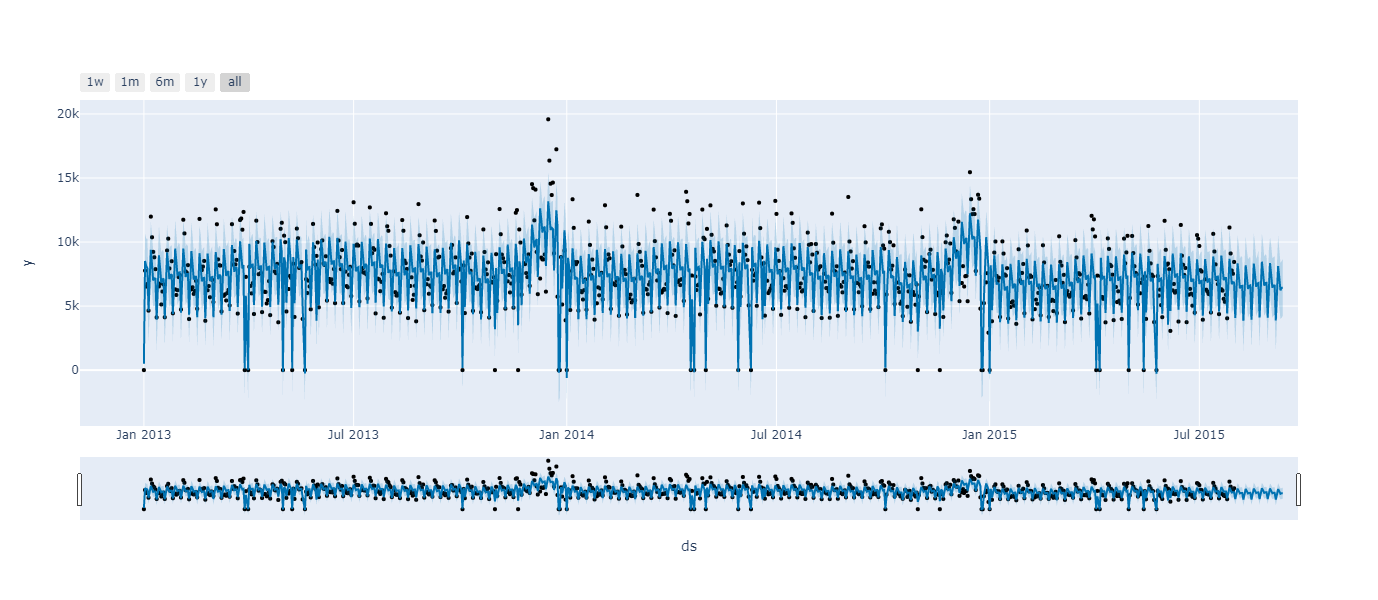

In [38]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

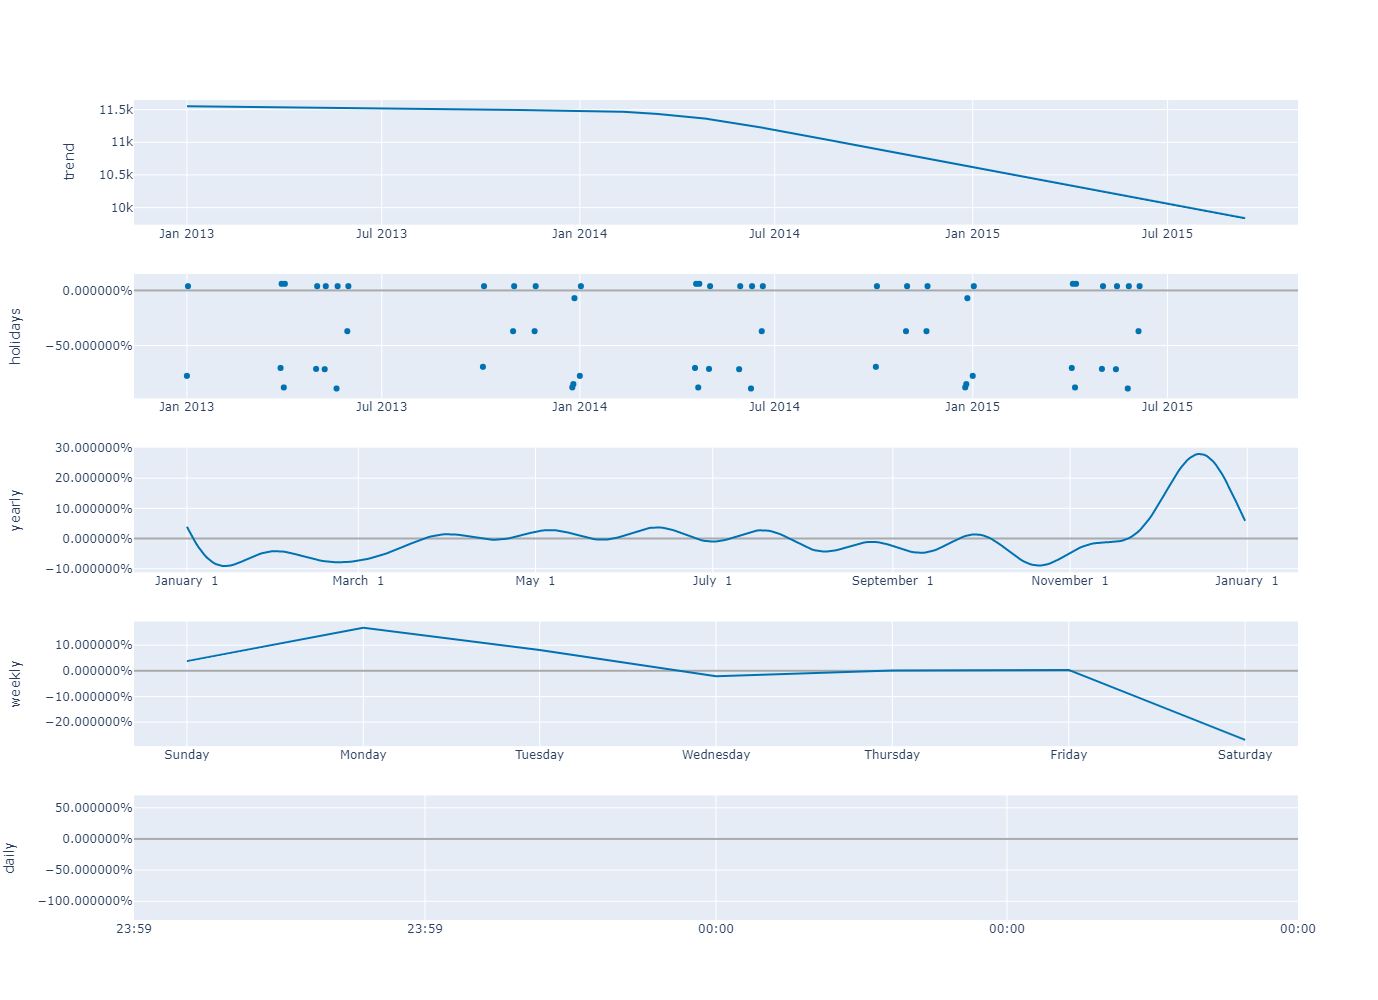

In [39]:
plot_components_plotly(m, forecast)

In [ ]:
# Recordar que los domingos los quitamos del dataset para que no ensucie los gráficos.
# Hay que plancharles un 0 a esos días cuando lo entreguemos.